In [1]:
import torch
from torch import nn, optim
from neurodiffeq import diff
from neurodiffeq.networks import FCNN
from neurodiffeq.temporal import generator_2dspatial_rectangle, generator_2dspatial_segment, generator_temporal
from neurodiffeq.temporal import FirstOrderInitialCondition, BoundaryCondition
from neurodiffeq.temporal import SingleNetworkApproximator2DSpatialTemporal
from neurodiffeq.temporal import Monitor2DSpatialTemporal
from neurodiffeq.temporal import _solve_2dspatial_temporal
import numpy as np
import matplotlib.pyplot as plt

In [2]:
DIFFUSIVITY = 0.3
X_MIN, X_MAX = -1.0, 1.0
Y_MIN, Y_MAX = -1.0, 1.0
T_MIN, T_MAX = 0.0, 6.0

def heat_equation_2d(u, x, y, t):
    left = diff(u, t) - DIFFUSIVITY*(diff(u, x, order=2) + diff(u, y, order=2))
    right = -torch.exp(-t) * ((X_MAX-x)*(x-X_MIN)*(Y_MAX-y)*(y-Y_MIN) - 2*DIFFUSIVITY*((Y_MAX-y)*(y-Y_MIN)+(X_MAX-x)*(x-X_MIN)))
    return left - right

def analytical_solution(xx, yy, tt):
    return torch.exp(-tt) * (X_MAX-xx)*(xx-X_MIN)*(Y_MAX-yy)*(yy-Y_MIN)

metrics = {}
def rmse(uu, xx, yy, tt):
    error = uu - analytical_solution(xx, yy, tt)
    return torch.mean(error**2)**0.5
metrics['rmse'] = rmse
# def non_reg_loss(uu, xx, yy, tt):
#     return torch.mean(heat_equation_2d(uu, xx, yy, tt)**2)
# metrics['non_reg_loss'] = non_reg_loss

In [3]:
def u0(x, y):
    return (X_MAX - x) * (x - X_MIN) * (Y_MAX - y) * (y - Y_MIN)

initial_condition = FirstOrderInitialCondition(u0=u0)

dirichlet_boundary_left  = BoundaryCondition(
    form=lambda u, x, y, t: u,
    points_generator=generator_2dspatial_segment(size=32, start=(X_MIN, Y_MIN), end=(X_MIN, Y_MAX))
)
dirichlet_boundary_right = BoundaryCondition(
    form=lambda u, x, y, t: u,
    points_generator=generator_2dspatial_segment(size=32, start=(X_MAX, Y_MIN), end=(X_MAX, Y_MAX))
)
dirichlet_boundary_upper = BoundaryCondition(
    form=lambda u, x, y, t: u,
    points_generator=generator_2dspatial_segment(size=32, start=(X_MIN, Y_MAX), end=(X_MAX, Y_MAX))
)
dirichlet_boundary_lower = BoundaryCondition(
    form=lambda u, x, y, t: u,
    points_generator=generator_2dspatial_segment(size=32, start=(X_MIN, Y_MIN), end=(X_MAX, Y_MIN))
)

train_gen_spatial = generator_2dspatial_rectangle(
    size=(16, 16), x_min=X_MIN, x_max=X_MAX, y_min=Y_MIN, y_max=Y_MAX
)
train_gen_temporal = generator_temporal(size=32, t_min=T_MIN, t_max=T_MAX)
valid_gen_spatial = generator_2dspatial_rectangle(
    size=(8, 8), x_min=X_MIN, x_max=X_MAX, y_min=Y_MIN, y_max=Y_MAX, random=False
)
valid_gen_temporal = generator_temporal(size=16, t_min=T_MIN, t_max=T_MAX, random=False)
monitor = Monitor2DSpatialTemporal(
    check_on_x=torch.linspace(X_MIN, X_MAX, 32),
    check_on_y=torch.linspace(Y_MIN, Y_MAX, 32),
    check_on_t=torch.linspace(T_MIN, T_MAX, 4),
    check_every=10
)

fcnn = FCNN(
        n_input_units=3,
        n_output_units=1,
        n_hidden_units=32,
        n_hidden_layers=1,
        actv=nn.Tanh
)
# def length_factor(x, y):
#     scale = (X_MAX-X_MIN)**2*(Y_MAX-Y_MIN)**2/16.
#     return 1. - (X_MAX - x) * (x - X_MIN) * (Y_MAX - y) * (y - Y_MIN) / scale
fcnn_approximator = SingleNetworkApproximator2DSpatialTemporal(
    single_network=fcnn,
    pde=heat_equation_2d,
    initial_condition=initial_condition,
    boundary_conditions=[
        dirichlet_boundary_left, 
        dirichlet_boundary_right, 
        dirichlet_boundary_upper, 
        dirichlet_boundary_lower
    ]
)
adam = optim.Adam(fcnn_approximator.parameters())

$$\partial_{t} u - k(\partial_{xx} u + \partial_{yy} u) = f(x, y)$$

$$u(x, y) = e^{-t}(x_{max}-x)(x-x_{min})(y_{max}-y)(y-y_{min})$$

<IPython.core.display.Javascript object>


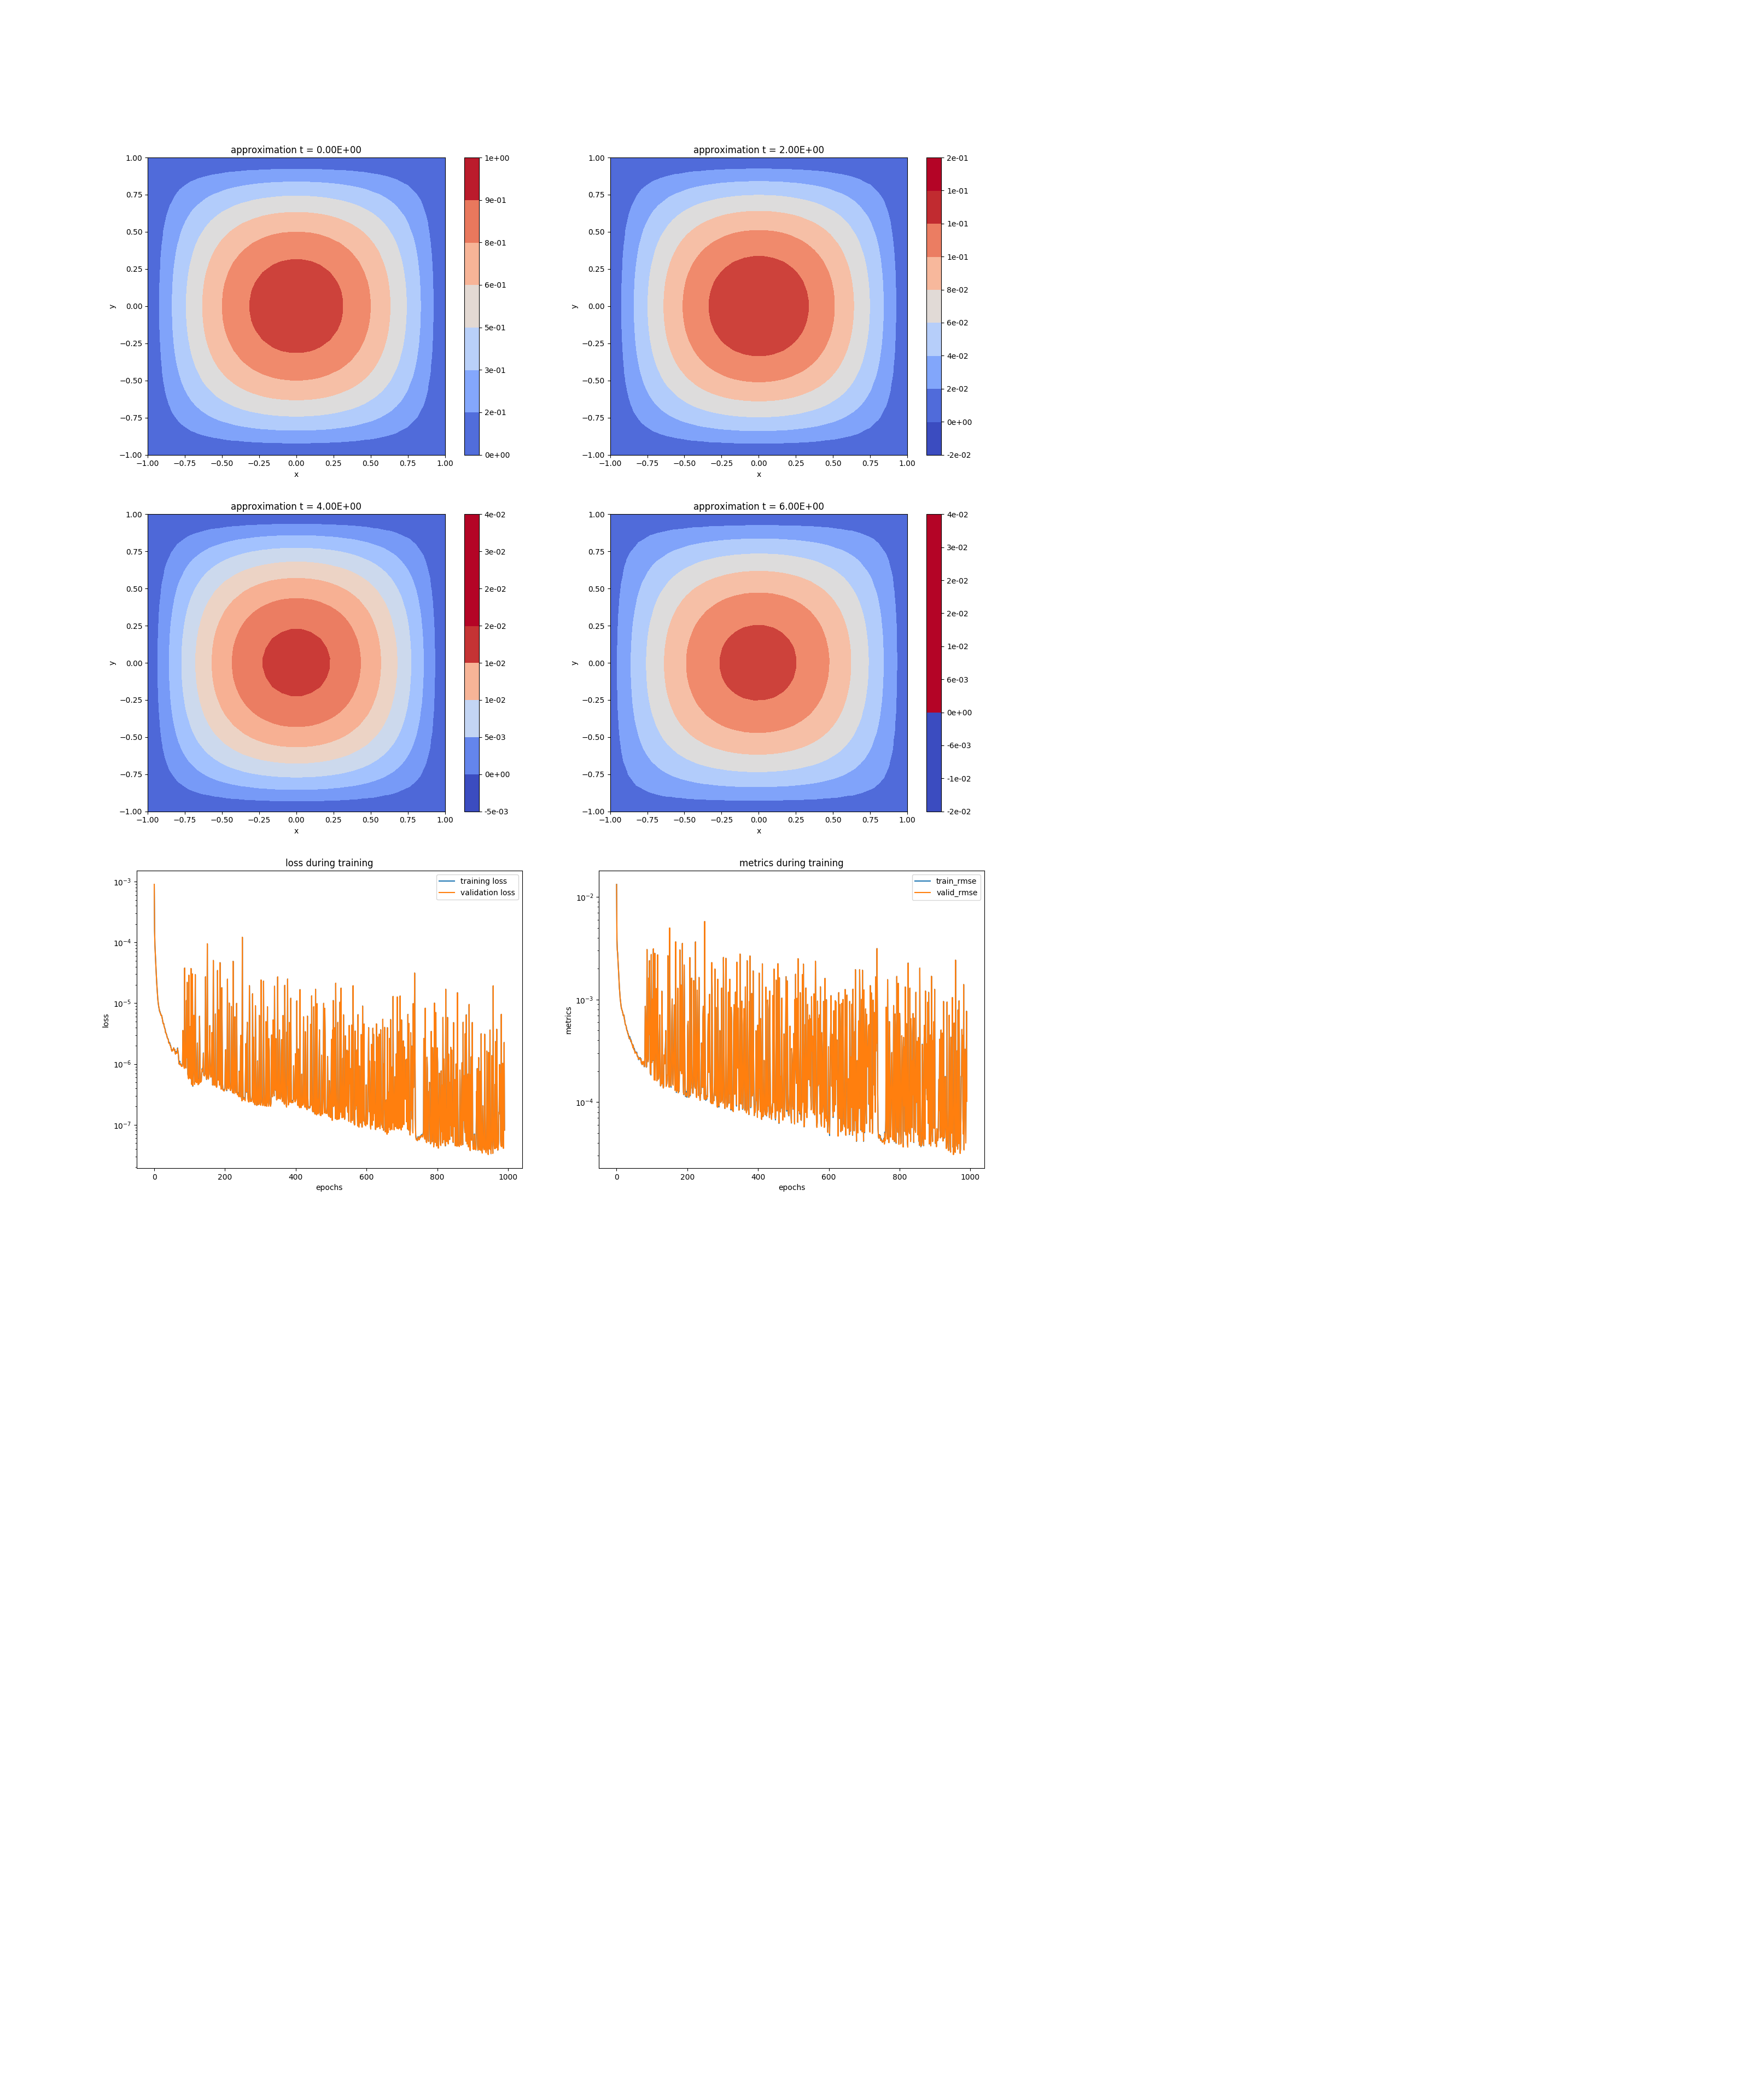

In [4]:
%matplotlib notebook
heat_equation_2d_solution, _ = _solve_2dspatial_temporal(
    train_generator_spatial=train_gen_spatial,
    train_generator_temporal=train_gen_temporal,
    valid_generator_spatial=valid_gen_spatial,
    valid_generator_temporal=valid_gen_temporal,
    approximator=fcnn_approximator,
    optimizer=adam,
    batch_size=256,
    max_epochs=1000,
    shuffle=True,
    metrics=metrics,
    monitor=monitor
)
%matplotlib inline

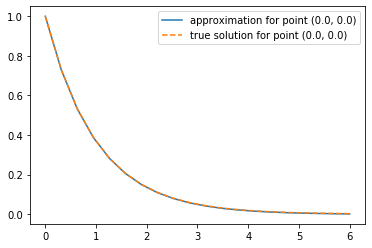

In [5]:
n = 20
t = np.linspace(T_MIN, T_MAX, n)

u_net = heat_equation_2d_solution(
    torch.zeros(n), torch.zeros(n),
    torch.linspace(T_MIN, T_MAX, n)
).detach().numpy()
u_ana = analytical_solution(
    torch.zeros(n), torch.zeros(n),
    torch.linspace(T_MIN, T_MAX, n)
).detach().numpy()
plt.plot(t, u_net, label='approximation for point (0.0, 0.0)')
plt.plot(t, u_ana, label='true solution for point (0.0, 0.0)', linestyle='--')
plt.legend();

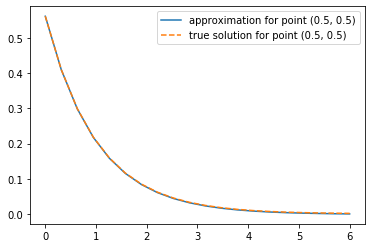

In [6]:
u_net = heat_equation_2d_solution(
    torch.ones(n)*0.5, torch.ones(n)*0.5,
    torch.linspace(T_MIN, T_MAX, n)
).detach().numpy()
u_ana = analytical_solution(
    torch.ones(n)*0.5, torch.ones(n)*0.5,
    torch.linspace(T_MIN, T_MAX, n)
).detach().numpy()
plt.plot(t, u_net, label='approximation for point (0.5, 0.5)')
plt.plot(t, u_ana, label='true solution for point (0.5, 0.5)', linestyle='--')
plt.legend();

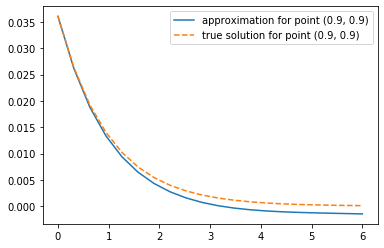

In [7]:
u_net = heat_equation_2d_solution(
    torch.ones(n)*0.9, torch.ones(n)*0.9,
    torch.linspace(T_MIN, T_MAX, n)
).detach().numpy()
u_ana = analytical_solution(
    torch.ones(n)*0.9, torch.ones(n)*0.9,
    torch.linspace(T_MIN, T_MAX, n)
).detach().numpy()
plt.plot(t, u_net, label='approximation for point (0.9, 0.9)')
plt.plot(t, u_ana, label='true solution for point (0.9, 0.9)', linestyle='--')
plt.legend();

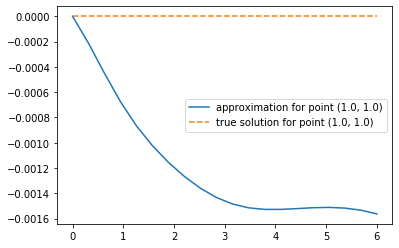

In [8]:
u_net = heat_equation_2d_solution(
    torch.ones(n), torch.ones(n),
    torch.linspace(T_MIN, T_MAX, n)
).detach().numpy()
u_ana = analytical_solution(
    torch.ones(n), torch.ones(n),
    torch.linspace(T_MIN, T_MAX, n)
).detach().numpy()
plt.plot(t, u_net, label='approximation for point (1.0, 1.0)')
plt.plot(t, u_ana, label='true solution for point (1.0, 1.0)', linestyle='--')
plt.legend();